In [1]:
%matplotlib inline

# Clustering text documents using k-means

Ini adalah contoh yang menunjukkan bagaimana scikit-learn dapat digunakan untuk mengelompokkan dokumen berdasarkan topik menggunakan pendekatan bag-of-words. Contoh ini menggunakan matriks scipy.sparse untuk menyimpan fitur alih-alih array numpy standar.

Dua metode ekstraksi fitur dapat digunakan dalam contoh ini:

    - TfidfVectorizer menggunakan kosakata dalam memori (dikt python) untuk memetakan kata yang paling sering ke indeks fitur dan karenanya menghitung matriks frekuensi kemunculan kata (jarang). Frekuensi kata kemudian dibobot ulang menggunakan vektor Inverse Document Frequency (IDF) yang dikumpulkan berdasarkan fitur di atas korpus.
    - HashingVectorizer meng-hash kemunculan kata ke ruang dimensi tetap, mungkin dengan tabrakan. Vektor jumlah kata kemudian dinormalisasi untuk masing-masing memiliki l2-norma sama dengan satu (diproyeksikan ke bola unit euclidean) yang tampaknya penting untuk k-means untuk bekerja di ruang dimensi tinggi.

        HashingVectorizer tidak memberikan pembobotan IDF karena ini adalah model tanpa kewarganegaraan (metode fit tidak melakukan apa pun). Saat pembobotan IDF diperlukan, pembobotan dapat ditambahkan dengan menyalurkan outputnya ke instans TfidfTransformer.

Dua algoritma didemonstrasikan: k-means biasa dan sepupunya yang lebih skalabel minibatch k-means.

Selain itu, analisis semantik laten juga dapat digunakan untuk mengurangi dimensi dan menemukan pola laten dalam data.

Dapat dicatat bahwa k-means (dan minibatch k-means) sangat sensitif terhadap penskalaan fitur dan dalam hal ini pembobotan IDF membantu meningkatkan kualitas pengelompokan dengan cukup banyak yang diukur terhadap "kebenaran dasar" yang disediakan oleh tugas label kelas dari 20 kumpulan data newsgroup.

Peningkatan ini tidak terlihat dalam Koefisien Silhouette yang kecil untuk keduanya karena ukuran ini tampaknya mengalami fenomena yang disebut "Konsentrasi Ukuran" atau "Kutukan Dimensi" untuk kumpulan data dimensi tinggi seperti data teks. Ukuran-ukuran lain seperti V-measure dan Adjusted Rand Index adalah skor evaluasi berbasis teori informasi: karena mereka hanya didasarkan pada penugasan cluster daripada jarak, karenanya tidak terpengaruh oleh kutukan dimensi.

Catatan: karena k-means mengoptimalkan fungsi tujuan non-cembung, kemungkinan akan berakhir di optimal lokal. Beberapa run dengan init acak independen mungkin diperlukan untuk mendapatkan konvergensi yang baik.

## Import Library

In [ ]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Lars Buitinck
# License: BSD 3 clause

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np

In [ ]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

# parse commandline arguments
op = OptionParser()
op.add_option(
    "--lsa",
    dest="n_components",
    type="int",
    help="Preprocess documents with latent semantic analysis.",
)
op.add_option(
    "--no-minibatch",
    action="store_false",
    dest="minibatch",
    default=True,
    help="Use ordinary k-means algorithm (in batch mode).",
)
op.add_option(
    "--no-idf",
    action="store_false",
    dest="use_idf",
    default=True,
    help="Disable Inverse Document Frequency feature weighting.",
)
op.add_option(
    "--use-hashing",
    action="store_true",
    default=False,
    help="Use a hashing feature vectorizer",
)
op.add_option(
    "--n-features",
    type=int,
    default=10000,
    help="Maximum number of features (dimensions) to extract from text.",
)
op.add_option(
    "--verbose",
    action="store_true",
    dest="verbose",
    default=False,
    help="Print progress reports inside k-means algorithm.",
)

print(__doc__)
op.print_help()
print()


def is_interactive():
    return not hasattr(sys.modules["__main__"], "__file__")


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)


# #############################################################################
# Load some categories from the training set
categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]
# Uncomment the following to do the analysis on all the categories
# categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

dataset = fetch_20newsgroups(
    subset="all", categories=categories, shuffle=True, random_state=42
)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print()

labels = dataset.target
true_k = np.unique(labels).shape[0]

print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    if opts.use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(
            n_features=opts.n_features,
            stop_words="english",
            alternate_sign=False,
            norm=None,
        )
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(
            n_features=opts.n_features,
            stop_words="english",
            alternate_sign=False,
            norm="l2",
        )
else:
    vectorizer = TfidfVectorizer(
        max_df=0.5,
        max_features=opts.n_features,
        min_df=2,
        stop_words="english",
        use_idf=opts.use_idf,
    )
X = vectorizer.fit_transform(dataset.data)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

if opts.n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print(
        "Explained variance of the SVD step: {}%".format(int(explained_variance * 100))
    )

    print()


# #############################################################################
# Do the actual clustering

if opts.minibatch:
    km = MiniBatchKMeans(
        n_clusters=true_k,
        init="k-means++",
        n_init=1,
        init_size=1000,
        batch_size=1000,
        verbose=opts.verbose,
    )
else:
    km = KMeans(
        n_clusters=true_k,
        init="k-means++",
        max_iter=100,
        n_init=1,
        verbose=opts.verbose,
    )

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, km.labels_))
print(
    "Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(X, km.labels_, sample_size=1000)
)

print()


if not opts.use_hashing:
    print("Top terms per cluster:")

    if opts.n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names_out()
    for i in range(true_k):
        print("Cluster %d:" % i, end="")
        for ind in order_centroids[i, :10]:
            print(" %s" % terms[ind], end="")
        print()

2021-10-26 17:27:22,386 INFO Downloading 20news dataset. This may take a few minutes.
2021-10-26 17:27:22,388 INFO Downloading dataset from https://ndownloader.figshare.com/files/5975967 (14 MB)


Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --lsa=N_COMPONENTS    Preprocess documents with latent semantic analysis.
  --no-minibatch        Use ordinary k-means algorithm (in batch mode).
  --no-idf              Disable Inverse Document Frequency feature weighting.
  --use-hashing         Use a hashing feature vectorizer
  --n-features=N_FEATURES
                        Maximum number of features (dimensions) to extract
                        from text.
  --verbose             Print progress reports inside k-means algorithm.

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
3387 documents
4 categories

Extracting features from the training dataset using a sparse vectorizer
done in 1.989554s
n_samples: 3387, n_features: 10000

Clustering sparse data with MiniBatchKMeans(batch_size=1000, init_si

# ANOTHER EXAMPLE

## IMPORT LIBRARY

In [9]:
import numpy
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def load_image(image):
    image = Image.open(image)
    im_array = numpy.array(image)

    red = im_array[:, :, 0]
    green = im_array[:, :, 1]
    blue = im_array[:, :, 2]

    return red, green, blue

In [6]:
def channel_compress(color_channel, singular_value_limit):
    u, s, v = numpy.linalg.svd(color_channel)
    compressed = numpy.zeros((color_channel.shape[0], color_channel.shape[1]))
    n = singular_value_limit

    left_matrix = numpy.matmul(u[:, 0:n], numpy.diag(s)[0:n, 0:n])
    inner_compressed = numpy.matmul(left_matrix, v[0:n, :])
    compressed = inner_compressed.astype('uint8')
    return compressed

image_cat = load_image("dataset/cat.jpeg")
red, green, blue = image_cat
singular_val_lim = 350

In [7]:
red, green, blue = image_cat
singular_val_lim = 350

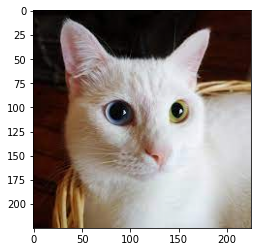

In [11]:
def compress_image(red, green, blue, singular_val_lim):
    compressed_red = channel_compress(red, singular_val_lim)
    compressed_green = channel_compress(green, singular_val_lim)
    compressed_blue = channel_compress(blue, singular_val_lim)

    im_red = Image.fromarray(compressed_red)
    im_blue = Image.fromarray(compressed_blue)
    im_green = Image.fromarray(compressed_green)

    new_image = Image.merge("RGB", (im_red, im_green, im_blue))
    plt.imshow(new_image)
    plt.show()

compress_image(red, green, blue, singular_val_lim)